### This notebook involves the Cervical Cancer Risk classification based on risk factors for Cervical cancer.

### Install & import required libraries

In [ ]:
!pip install scikit-plot

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report,auc
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
import joblib 

import plotly.offline as pyoff
import plotly.graph_objs as go

import lightgbm as lgb
import pickle

import warnings
warnings.filterwarnings('ignore')

### **Dataset**

In this task we are using [Cervical Cancer Risk Classification](https://www.kaggle.com/loveall/cervical-cancer-risk-classification) dataset from Kaggle.

Description:

This file contains a List of Risk Factors for Cervical Cancer leading to a Biopsy Examination!

About 11,000 new cases of invasive cervical cancer are diagnosed each year in the U.S. However, the number of new cervical cancer cases has been declining steadily over the past decades. Although it is the most preventable type of cancer, each year cervical cancer kills about 4,000 women in the U.S. and about 300,000 women worldwide. In the United States, cervical cancer mortality rates plunged by 74% from 1955 - 1992 thanks to increased screening and early detection with the Pap test. AGE Fifty percent of cervical cancer diagnoses occur in women ages 35 - 54, and about 20% occur in women over 65 years of age. The median age of diagnosis is 48 years. About 15% of women develop cervical cancer between the ages of 20 - 30. Cervical cancer is extremely rare in women younger than age 20. However, many young women become infected with multiple types of human papilloma virus, which then can increase their risk of getting cervical cancer in the future. Young women with early abnormal changes who do not have regular examinations are at high risk for localized cancer by the time they are age 40, and for invasive cancer by age 50. HIGH SEXUAL ACTIVITY Human papilloma virus (HPV) is the main risk factor for cervical cancer. In adults, the most important risk factor for HPV is sexual activity with an infected person. Women most at risk for cervical cancer are those with a history of multiple sexual partners, sexual intercourse at age 17 years or younger, or both. A woman who has never been sexually active has a very low risk for developing cervical cancer. FAMILY HISTORY Women have a higher risk of cervical cancer if they have a first-degree relative (mother, sister) who has had cervical cancer. USE OF ORAL CONTRACEPTIVES Studies have reported a strong association between cervical cancer and long-term use of oral contraception (OC). Women who take birth control pills for more than 5 - 10 years appear to have a much higher risk HPV infection (up to four times higher) than those who do not use OCs. (Women taking OCs for fewer than 5 years do not have a significantly higher risk.) HAVING MANY CHILDREN Studies indicate that having many children increases the risk for developing cervical cancer, particularly in women infected with HPV. SMOKING Smoking is associated with a higher risk for precancerous changes (dysplasia) in the cervix and for progression to invasive cervical cancer, especially for women infected with HPV. IMMUNOSUPPRESSION Women with weak immune systems, (such as those with HIV / AIDS), are more susceptible to acquiring HPV. Immunocompromised patients are also at higher risk for having cervical precancer develop rapidly into invasive cancer.

### Read the dataset

In [ ]:
df = pd.read_csv('/content/kag_risk_factors_cervical_cancer.csv')

In [ ]:
df.head()

Age Number of sexual partners  ... Citology Biopsy
0   18                       4.0  ...        0      0
1   15                       1.0  ...        0      0
2   34                       1.0  ...        0      0
3   52                       5.0  ...        0      0
4   46                       3.0  ...        0      0

[5 rows x 36 columns]

In [ ]:
print('Shape of the dataset: {}'.format(df.shape))

Shape of the dataset: (858, 36)


In [ ]:
# Check dtypes
df.dtypes

Age                                    int64
Number of sexual partners             object
First sexual intercourse              object
Num of pregnancies                    object
Smokes                                object
Smokes (years)                        object
Smokes (packs/year)                   object
Hormonal Contraceptives               object
Hormonal Contraceptives (years)       object
IUD                                   object
IUD (years)                           object
STDs                                  object
STDs (number)                         object
STDs:condylomatosis                   object
STDs:cervical condylomatosis          object
STDs:vaginal condylomatosis           object
STDs:vulvo-perineal condylomatosis    object
STDs:syphilis                         object
STDs:pelvic inflammatory disease      object
STDs:genital herpes                   object
STDs:molluscum contagiosum            object
STDs:AIDS                             object
STDs:HIV  

In [ ]:
# Drop STDs: Time since first diagnosis & STDs: Time since last diagnosis, because these columns contains ? not numerical values.
df = df.drop(['STDs: Time since first diagnosis','STDs: Time since last diagnosis'],axis=1)

In [ ]:
# Select attributes which have object dtype
df_object = df.select_dtypes(include='object')
df_object_cols = df_object.columns.tolist()
df_object_cols

['Number of sexual partners',
 'First sexual intercourse',
 'Num of pregnancies',
 'Smokes',
 'Smokes (years)',
 'Smokes (packs/year)',
 'Hormonal Contraceptives',
 'Hormonal Contraceptives (years)',
 'IUD',
 'IUD (years)',
 'STDs',
 'STDs (number)',
 'STDs:condylomatosis',
 'STDs:cervical condylomatosis',
 'STDs:vaginal condylomatosis',
 'STDs:vulvo-perineal condylomatosis',
 'STDs:syphilis',
 'STDs:pelvic inflammatory disease',
 'STDs:genital herpes',
 'STDs:molluscum contagiosum',
 'STDs:AIDS',
 'STDs:HIV',
 'STDs:Hepatitis B',
 'STDs:HPV']

In [ ]:
# Replace '?' with np.nan
df = df.replace('?',np.nan)

In [ ]:
# Convert object dtype to float dtype
for col in df_object_cols:
  df[col] = df[col].astype('float64')

In [ ]:
df.head()

Age  Number of sexual partners  ...  Citology  Biopsy
0   18                        4.0  ...         0       0
1   15                        1.0  ...         0       0
2   34                        1.0  ...         0       0
3   52                        5.0  ...         0       0
4   46                        3.0  ...         0       0

[5 rows x 34 columns]

In [ ]:
# Check NAN values
df.isnull().sum()

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

It seems 25 attributes have null values.

###  **Exploratory Data Analysis**

It seems like our data fall under two categories:
* Categorical features: smokes, IUD, STDs etc
* Numerical features: Number of sexual partners, Num of pregnancies, Age etc

Now starting from the categorical ones, we shed light on all features and see how helpful they are to identify if Cervical cancer is positive.

In [ ]:
# Define a function for Categorcal features
def categorical_features(df, cat_column):
  df_plot = df.groupby(cat_column)['Dx:Cancer'].mean().reset_index()
  plot_data = [
      go.Bar(
          x=df_plot[cat_column],
          y=df_plot['Dx:Cancer'],
          width = [0.5, 0.5],
          marker=dict(
          color=['green', 'blue'])
      )
  ]
  plot_layout = go.Layout(
          xaxis={"type": "category",'title':cat_column},
          yaxis={"title": "Cervical cancer positive rate"},
          title= cat_column,
          plot_bgcolor  = 'rgb(243,243,243)',
          paper_bgcolor  = 'rgb(243,243,243)',
      )
  fig = go.Figure(data=plot_data, layout=plot_layout)
  return fig

**Smokes**

In [ ]:
smokes_fig = categorical_features(df,'Smokes')
pyoff.iplot(smokes_fig)

1- Smoker, 0 - Non-Smoker

Smokes breakdown for Cervical cancer:

In [ ]:
df.groupby('Smokes')['Dx:Cancer'].mean()

Smokes
0.0    0.020776
1.0    0.016260
Name: Dx:Cancer, dtype: float64

A Non-smoker is more likely to get Cervical cancer ( ~2.1%) than Smoker ( ~1.6%).

**Hormonal Contraceptives**

In [ ]:
hc_fig = categorical_features(df,'Hormonal Contraceptives')
pyoff.iplot(hc_fig)

0 - False, 1- True

Hormonal Contraceptives breakdown for Cervical cancer.

In [ ]:
df.groupby('Hormonal Contraceptives')['Dx:Cancer'].mean()

Hormonal Contraceptives
0.0    0.018587
1.0    0.027027
Name: Dx:Cancer, dtype: float64

It seems Women who use Hormonal Contraceptives appear to have  higher probability of getting  Cervical cancer ( ~2.7%) than who don't use( ~1.8%). 

**IUD** (Intrauterine Device)

In [ ]:
iud_fig  = categorical_features(df,'IUD')
pyoff.iplot(iud_fig)

0 - False, 1 - True

IUD breakdown for Cervical cancer:

In [ ]:
df.groupby('IUD')['Dx:Cancer'].mean()

IUD
0.0    0.018237
1.0    0.072289
Name: Dx:Cancer, dtype: float64

Women who use IUD have higher chances of getting Cervical cancer (~ 7.2%) than who don't (~1.8%).

**STDs**

In [ ]:
std_fig = categorical_features(df,'STDs')
pyoff.iplot(std_fig)

0 - False, 1 - True

STDs breakdown for Cervical cancer:

In [ ]:
df.groupby('STDs')['Dx:Cancer'].mean()

STDs
0.0    0.023739
1.0    0.025316
Name: Dx:Cancer, dtype: float64

It seems Women who have Sexually transmitted diseases (STDs) are more likely (~ 2.5%) to get Cervical cancer than who don't have (~ 2.37%).

**STDs:condylomatosis**

In [ ]:
condy_fig = categorical_features(df, 'STDs:condylomatosis')
pyoff.iplot(condy_fig)

0 - False, 1 - True

STDs:condylomatosis breakdown for Cervical cancer:

In [ ]:
df.groupby('STDs:condylomatosis')['Dx:Cancer'].mean()

STDs:condylomatosis
0.0    0.025388
1.0    0.000000
Name: Dx:Cancer, dtype: float64

Women who have not infected by STDs:condylomatosis are likely (~ 2..5%) to get Cervical cancer.

**STDs:cervical condylomatosis**

In [ ]:
cervical_fig = categorical_features(df, 'STDs:cervical condylomatosis')
pyoff.iplot(cervical_fig)

0 - False

 Women who don't have STDs:cervical condylomatosis are likely to get Cervicular cancer.

**STDs:vaginal condylomatosis**

In [ ]:
vaginal_fig = categorical_features(df,'STDs:vaginal condylomatosis')
pyoff.iplot(vaginal_fig)

0 - False, 1 - True

STDs:vaginal condylomatosis breakdown for Cervical cancer:


In [ ]:
df.groupby('STDs:vaginal condylomatosis')['Dx:Cancer'].mean()

STDs:vaginal condylomatosis
0.0    0.024032
1.0    0.000000
Name: Dx:Cancer, dtype: float64

Interestingly, Women who don't have STDs:vaginal condylomatosis are likely (~ 2.4%) to get Cervical cancer.

**STDs:vulvo-perineal condylomatosis**

In [ ]:
vulvo_fig = categorical_features(df, 'STDs:vulvo-perineal condylomatosis')
pyoff.iplot(vulvo_fig)

0 - False, 1 - True

STDs:vulvo-perineal condylomatosis breakdown for Cervical cancer:

In [ ]:
df.groupby('STDs:vulvo-perineal condylomatosis')['Dx:Cancer'].mean()

STDs:vulvo-perineal condylomatosis
0.0    0.025352
1.0    0.000000
Name: Dx:Cancer, dtype: float64

Women who infected by STDs:vulvo-perineal condylomatosis are not  likely (0.0%) to get Cervical cancer.

**STDs:syphilis**

In [ ]:
syphill_fig = categorical_features(df,'STDs:syphilis')
pyoff.iplot(syphill_fig)

0 - False, 1 - True

STDs:syphilis breakdown for Cervical cancer:

In [ ]:
df.groupby('STDs:syphilis')['Dx:Cancer'].mean()

STDs:syphilis
0.0    0.02449
1.0    0.00000
Name: Dx:Cancer, dtype: float64

Women who infected by STDs:syphilis are not likely to get Cervical cancer.

**STDs:pelvic inflammatory disease**

In [ ]:
pelvic_fig = categorical_features(df,'STDs:pelvic inflammatory disease')
pyoff.iplot(pelvic_fig)

0 - False, 1 - True

STDs:pelvic inflammatory disease breakdown for Cervical cancer:

In [ ]:
df.groupby('STDs:pelvic inflammatory disease')['Dx:Cancer'].mean()

STDs:pelvic inflammatory disease
0.0    0.023936
1.0    0.000000
Name: Dx:Cancer, dtype: float64

Women who infected by STDs:pelvic inflammatory are not likely to get Cervical cancer.

**STDs:genital herpes**

In [ ]:
genital_fig = categorical_features(df,'STDs:genital herpes')
pyoff.iplot(genital_fig)

0 - False, 1 - True

STDs:genital herpes breakdown for Cervical cancer:

In [ ]:
df.groupby('STDs:genital herpes')['Dx:Cancer'].mean()

STDs:genital herpes
0.0    0.023936
1.0    0.000000
Name: Dx:Cancer, dtype: float64

Women who have STDs:genital herpes are not likely  to get Cervical cancer.

**STDs:molluscum contagiosum**

In [ ]:
molluscum_fig = categorical_features(df,'STDs:molluscum contagiosum')
pyoff.iplot(molluscum_fig)

0 - False, 1 - True

Women who infected by STDs:molluscum contagiosum are not likely  to get Cervical cancer.

**STDs:AIDS**

In [ ]:
AIDS_fig = categorical_features(df,'STDs:AIDS')
pyoff.iplot(AIDS_fig)

0 - False

Women who infected by STDs:AIDS are not likely to get Cervical cancer.

**STDs:HIV**

In [ ]:
HIV_fig = categorical_features(df,'STDs:HIV')
pyoff.iplot(HIV_fig)

0 - False, 1 -True

STDs:HIV breakdown for Cervical cancer:

In [ ]:
df.groupby('STDs:HIV')['Dx:Cancer'].mean()

STDs:HIV
0.0    0.02449
1.0    0.00000
Name: Dx:Cancer, dtype: float64

HIV positive women are not likey  to get Cervical cancer.

**STDs:Hepatitis B**

In [ ]:
HB_fig = categorical_features(df,'STDs:Hepatitis B')
pyoff.iplot(HB_fig)

0 - False, 1 - True

STDs:Hepatitis B breakdown for Cervical cancer:

In [ ]:
df.groupby('STDs:Hepatitis B')['Dx:Cancer'].mean()

STDs:Hepatitis B
0.0    0.023936
1.0    0.000000
Name: Dx:Cancer, dtype: float64

It seems Women who have Hepatitis B  are not likely to get Cervical cancer.

**STDs:HPV**

In [ ]:
HPV_fig = categorical_features(df, 'STDs:HPV')
pyoff.iplot(HPV_fig)

0 - False, 1 - True

Women who infected by STDs:HPV have  higher chances to getting Cervical cancer.

**Biopsy**

In [ ]:
cancer_fig = categorical_features(df, 'Biopsy')
pyoff.iplot(cancer_fig)

0 - False, 1 - True

Biopsy breakdown for Dx:Cancer:

In [ ]:
df.groupby('Biopsy')['Dx:Cancer'].mean()

Biopsy
0    0.014944
1    0.109091
Name: Dx:Cancer, dtype: float64

Women who have taken Biopsy are more likely (~10.9%) tested positive for Cervical cancer than who have not(1.5%).

**Dx:CIN**

In [ ]:
CIN_fig = categorical_features(df,'Dx:CIN')
pyoff.iplot(CIN_fig)

0 - False, 1 - True

Dx:CIN breakdown for Dx:Cancer:

In [ ]:
df.groupby('Dx:CIN')['Dx:Cancer'].mean()

Dx:CIN
0    0.021201
1    0.000000
Name: Dx:Cancer, dtype: float64

Women who experienced abnormal growth of cells on the surface of the cervix (Dx:CIN) are not likely to test positive for Cervical cancer. 


**Dx**

In [ ]:
dx_fig = categorical_features(df,'Dx')
pyoff.iplot(dx_fig)

0 - False, 1 - True

Dx breakdown for Dx:Cancer:

In [ ]:
df.groupby('Dx')['Dx:Cancer'].mean()

Dx
0    0.004796
1    0.583333
Name: Dx:Cancer, dtype: float64

Women who have Dx are more likely (~ 58.33%) to test positive for Cervical cancer.

**Dx:HPV**

In [ ]:
dxhpv_fig = categorical_features(df,'Dx:HPV')
pyoff.iplot(dxhpv_fig)

Women who have Dx:HPV are more likely to test positive for Cervical cancer.

**Hinselmann**

In [ ]:
hins_fig = categorical_features(df,'Hinselmann')
pyoff.iplot(hins_fig)

0 - False, 1 - True

Hinselmann breakdown for Dx:Cancer:

In [ ]:
df.groupby('Hinselmann')['Dx:Cancer'].mean()

Hinselmann
0    0.017011
1    0.114286
Name: Dx:Cancer, dtype: float64

Women who have Hinselmann  are more likely(~11.4%) to test positive for Cervical cancer.

**Schiller**

In [ ]:
Schiller_fig = categorical_features(df,'Schiller')
pyoff.iplot(Schiller_fig)

0 - False, 1 - True

Schiller breakdown for Dx:Cancer:

In [ ]:
df.groupby('Schiller')['Dx:Cancer'].mean()

Schiller
0    0.014031
1    0.094595
Name: Dx:Cancer, dtype: float64

Women who have Schiller are more likely (~ 9..46%) to test positive for Cervical cancer than who have not (~1.4%).

**Citology**

In [ ]:
Citology_fig = categorical_features(df,'Citology')
pyoff.iplot(Citology_fig)

0 - False, 1 - True

Citology breakdown for Dx:Cancer:

In [ ]:
df.groupby('Citology')['Dx:Cancer'].mean()

Citology
0    0.017199
1    0.090909
Name: Dx:Cancer, dtype: float64

It seems women who have undergone Citology test are more likely (~ 9.1%) to test positive for Cervical cancer than who haven't (~ 1.7%).

We are done with the categorical features. Let’s see how numerical features look like:

### **Numerical features**

In [ ]:
# Define a function for numerical features
def numerical_feature(df, col):
  df_plot = df.groupby(col)['Dx:Cancer'].mean().reset_index()
  plot_data = [
      go.Scatter(
          x=df_plot[col],
          y=df_plot['Dx:Cancer'],
          mode='markers',
          name='Low',
          marker= dict(size= 7,
              line= dict(width=1),
              color= 'blue',
              opacity= 0.8
            ),
      )
  ]
  plot_layout = go.Layout(
          yaxis= {'title': "Cervical cancer positive rate"},
          xaxis= {'title': col},
          title='{} based Cervical cancer positive rate'.format(col),
          plot_bgcolor  = "rgb(243,243,243)",
          paper_bgcolor  = "rgb(243,243,243)",
      )
  fig = go.Figure(data=plot_data, layout=plot_layout)
  return fig

**Age**

In [ ]:
age_fig = numerical_feature(df,'Age')
pyoff.iplot(age_fig)

We can see no trend between Age & Cervical cancer positive rate. Women between age 20 & 40 are more likely to test positive for Cervicular cancer.

**Number of sexual partners**

In [ ]:
nsp_fig = numerical_feature(df,'Number of sexual partners')
pyoff.iplot(nsp_fig)

We can see upward trend between Cervicular cancer positive rate & Number of sexual partners till number 6 & then, the cancer rate became flat at 0.

**First sexual intercourse**

In [ ]:
fsi_fig = numerical_feature(df,'First sexual intercourse')
pyoff.iplot(fsi_fig)

We can see upward trend between Cervical cancer positive rate & First sexual intercourse till the age of 22 & then cancer rate became flat at 0.

**Num of pregnancies**

In [ ]:
np_fig = numerical_feature(df,'Num of pregnancies')
pyoff.iplot(np_fig)

We can see a upward trend between Cervical cancer positive rate & Num of pregnancies till the number of pregnancies of 5 & then became flat at 0.

**Smokes (years)**

In [ ]:
smoke_fig = numerical_feature(df,'Smokes (years)')
pyoff.iplot(smoke_fig)

We can see no trend between Cervical cancer positive rate & Smokes (years).

**Smokes (packs/year)**

In [ ]:
smoke_packs = numerical_feature(df, 'Smokes (packs/year)')
pyoff.iplot(smoke_packs)

There is no trend beween Cervical cancer positive rate & Smokes (packs/year).

**Hormonal Contraceptives (years)**

In [ ]:
HC_fig = numerical_feature(df,'Hormonal Contraceptives (years)')
pyoff.iplot(HC_fig)

We can see no trend between Cervical cancer positive rate & Hormonal Contraceptives (years).

**IUD (years)**

In [ ]:
IUD_fig = numerical_feature(df,'IUD (years)')
pyoff.iplot(IUD_fig)

No trend between Cervical cancer positive rate & IUD (years).

**STDs (number)**

In [ ]:
stds_fig = numerical_feature(df,'STDs (number)')
pyoff.iplot(stds_fig)

We can see a increasing trend between Cervical cancer positive rate & STDs (number) till the STDs number of 1 & then it became flat at 0.

**STDs: Number of diagnosis**

In [ ]:
diag_fig = numerical_feature(df,'STDs: Number of diagnosis')
pyoff.iplot(diag_fig)

There is a downward trend between Cervical cancer positive rate & STDs: Number of diagnosis.

Now, let's see how our target feature Dx:Cancer distributed.

Count of classes :
 0    840
1     18
Name: Dx:Cancer, dtype: int64
percentage of class count :
 0    97.902098
1     2.097902
Name: Dx:Cancer, dtype: float64
CPU times: user 79.5 ms, sys: 0 ns, total: 79.5 ms
Wall time: 79.5 ms


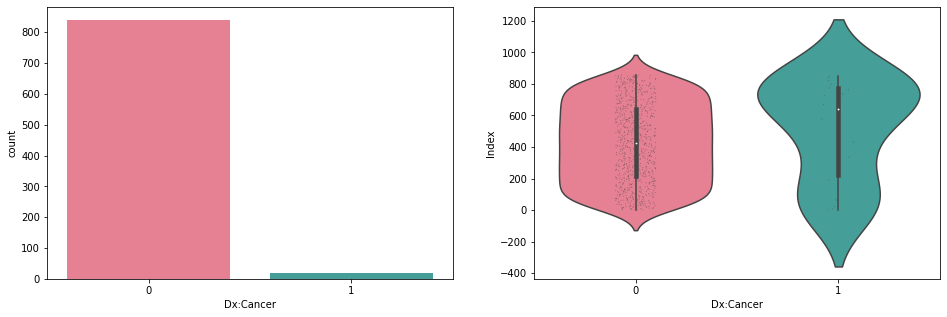

In [ ]:
%%time
#class count
df_class=df['Dx:Cancer'].value_counts()
print('Count of classes :\n',df_class)
#Percentage of class count
per_class=df['Dx:Cancer'].value_counts()/len(df)*100
print('percentage of class count :\n',per_class)

#Countplot and violin plot for label
fig,ax=plt.subplots(1,2,figsize=(16,5))
sns.countplot(df['Dx:Cancer'].values,ax=ax[0],palette='husl')
sns.violinplot(x=df['Dx:Cancer'].values,y=df.index.values,ax=ax[1],palette='husl')
sns.stripplot(x=df['Dx:Cancer'].values,y=df.index.values,jitter=True,color='black',linewidth=0.5,size=0.5,alpha=0.5,ax=ax[1],palette='husl')
ax[0].set_xlabel('Dx:Cancer')
ax[1].set_xlabel('Dx:Cancer')
ax[1].set_ylabel('Index')

Take aways:

* We have highly imbalanced data, where 97.9% of the data is the number of observations for which Cervical cancer is negatve  and 2.09% of the data is the number of observations for which Cervical cancer is positive.
* If you look at the jitter in violin plot, we can say that classes distributed uniformly over the indexs of the dataframe and Also we can observe the imbalanced class distribution where the  class 0 is most densely distributed than the class 1.

This unbalanced classes gives misleading results. So we are balancing the classes using SMOTE technique. 

### **Data-preprocessing**

Fill the missing values using KNN imputation.

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_final= imputer.fit_transform(df)

In [ ]:
df_final = pd.DataFrame(df_final,columns=df.columns)

In [ ]:
df_final

Age  Number of sexual partners  ...  Citology  Biopsy
0    18.0                        4.0  ...       0.0     0.0
1    15.0                        1.0  ...       0.0     0.0
2    34.0                        1.0  ...       0.0     0.0
3    52.0                        5.0  ...       0.0     0.0
4    46.0                        3.0  ...       0.0     0.0
..    ...                        ...  ...       ...     ...
853  34.0                        3.0  ...       0.0     0.0
854  32.0                        2.0  ...       0.0     0.0
855  25.0                        2.0  ...       1.0     0.0
856  33.0                        2.0  ...       0.0     0.0
857  29.0                        2.0  ...       0.0     0.0

[858 rows x 34 columns]

In [ ]:
# Check null values 
df_final.isnull().sum()

Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0


Now we don't have any null values.

In [ ]:
X_features = df_final.drop('Dx:Cancer',axis=1)
y = df_final['Dx:Cancer']

#### Split the dataset for training, validation, & testing.

In [ ]:
#Split the data into train (80%), validation(10%), & test set (10%).
X_train,X_test,y_train,y_test=train_test_split(X_features, y, random_state=42, test_size=0.2)
X_val,X_test,y_val,y_test=train_test_split(X_test, y_test, random_state=42, test_size=0.5)

**Feature selection**

**Chi-Square test for selecting best features**:       
A chi-square test is used in statistics to test the independence of two events. In our case, we used to determine the relationship between independent variables (features) & dependent variable (response or target). In simple words, higher the Chi-Square value the feature is more dependent on the response and it can be selected for model training.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
# Extract top 20 best features
bestfeatures = SelectKBest(score_func=chi2, k=20)
bf = bestfeatures.fit(X_train, y_train)
dfscores = pd.DataFrame(bf.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

In [ ]:
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['features','Score'] 
print(featureScores.nlargest(20,'Score'))

                              features       Score
27                              Dx:HPV  571.599119
28                                  Dx  296.345270
6                  Smokes (packs/year)  195.670339
5                       Smokes (years)   75.243637
24                            STDs:HPV   51.769231
0                                  Age   21.414434
31                            Citology   14.665908
10                         IUD (years)   14.090209
32                              Biopsy   12.254865
30                            Schiller    8.045048
8      Hormonal Contraceptives (years)    4.730703
29                          Hinselmann    4.412953
9                                  IUD    2.403633
3                   Num of pregnancies    1.865908
25           STDs: Number of diagnosis    1.197623
1            Number of sexual partners    0.752114
13                 STDs:condylomatosis    0.741753
16  STDs:vulvo-perineal condylomatosis    0.722437
12                       STDs (

In [ ]:
best_features = featureScores.nlargest(20,'Score')
best_columns = best_features.features.tolist()
# Top 20 features
best_columns

['Dx:HPV',
 'Dx',
 'Smokes (packs/year)',
 'Smokes (years)',
 'STDs:HPV',
 'Age',
 'Citology',
 'IUD (years)',
 'Biopsy',
 'Schiller',
 'Hormonal Contraceptives (years)',
 'Hinselmann',
 'IUD',
 'Num of pregnancies',
 'STDs: Number of diagnosis',
 'Number of sexual partners',
 'STDs:condylomatosis',
 'STDs:vulvo-perineal condylomatosis',
 'STDs (number)',
 'First sexual intercourse']

Dx:HPV is the most important risk factor for Cervical cancer followed by Dx, Smokes (packs/year), , Smokes (years) & STDs:HPV.

In [ ]:
# Update X_train, X_test, X_val for best_columns
X_train_best = X_train[best_columns]
X_test_best = X_test[best_columns]
X_val_best = X_val[best_columns]

**Correlation matrix**

Plot correlation matrix using heatmap to check how the features are correlated.

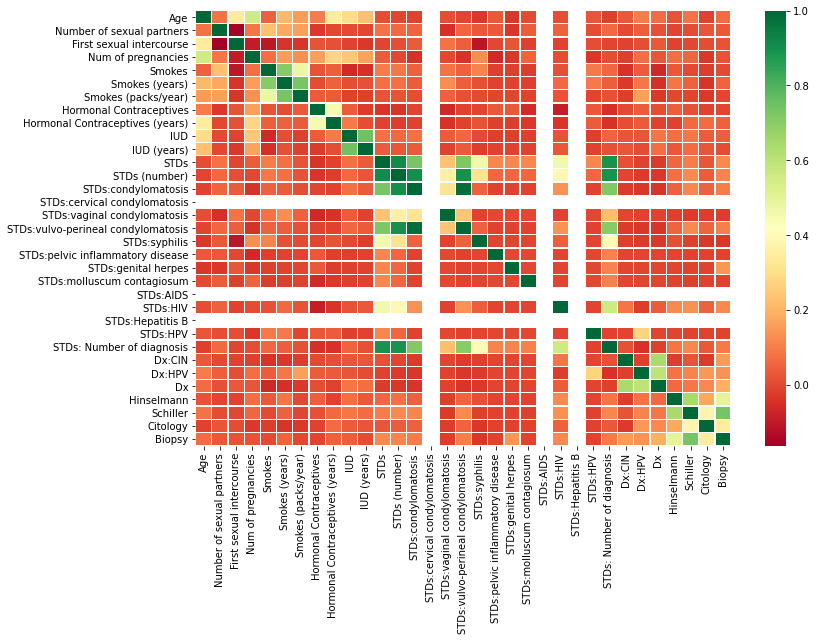

In [ ]:
plt.figure(figsize = (12,8))
df_corr = X_train.corr()
sns.heatmap(df_corr,fmt = "", cmap = "RdYlGn", linewidth = 0.30)
plt.show()

Insights:

* Features STDs & STDs: Number of diagnosis are highly positively correlated. This means these two are giving same information. So drop one variable from our dataset.
* Similarly features STDs (number) & STDs: Number of diagnosis are highly positively correlated. This means these two are giving same information. So drop one variable from our dataset.
* Similarly features STDs:vulvo-perineal condylomatosis & STDs (number) are highly positively correlated. This means these two are giving same information. So drop one variable from our dataset.
* Features STDs:condylomatosis & STDs:vulvo-perineal condylomatosis are highly positively correlated. Since these two features are giving same information drop one variable from our dataset.

In [ ]:
# Drop above variables according to  Correlation matrix for all datasets (train, val, & test)
drop_cols = ['STDs: Number of diagnosis','STDs:vulvo-perineal condylomatosis']
X_train = X_train_best.drop(drop_cols,axis=1)
# Validation dataset
X_val = X_val_best.drop(drop_cols,axis=1)
# test dataset
X_test = X_test_best.drop(drop_cols,axis=1)

**Handling Outliers**

Seaborn box plots to detect Outliers.

In [ ]:
# Define create_figure function for creating a Dashboard for Outlier detection
import matplotlib.gridspec as gridspec
def create_figure(plot1_f):
    with plt.style.context(("seaborn","ggplot")):
        fig = plt.figure(constrained_layout=True, figsize=(10,8))
        specs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig) ## Declaring 1x1 figure.

        ax1 = fig.add_subplot(specs[0, :]) 
        ## Box plot
        ax1.boxplot(X_train[plot1_f])
        ax1.set_ylabel(plot1_f)
        ax1.set_title("%s distribution through box plot"%(plot1_f))

        plt.close(fig)
        return fig

#### Create a Dashboard

In [ ]:
# Create a Dashboard
import panel as pn
import panel.widgets as pnw

We start by creating 1 dropdown which will have all features as options. We also have given names to each dropdown about which parameter it belongs to.

In [ ]:
f1 = pnw.Select(options=list(X_train.columns.to_list()), name="Box plot Feature")

We can link the above-mentioned widgets to a parameter of our method by creating wrapper function around it and giving it decorator (@pn.depends) as mentioned below. It'll link the value of these widgets with a value of a function.

In [ ]:
@pn.depends(f1.param.value)
def create_dash(f1):
    return create_figure(f1)

Column
    [0] StaticText(align='center', value='<h3>Dashboard :...)
    [1] Row(align='center')
        [0] Select(name='Box plot Feature', options=['Dx:HPV', 'Dx', ...], value='Dx:HPV')
    [2] Row
        [0] ParamFunction(function)
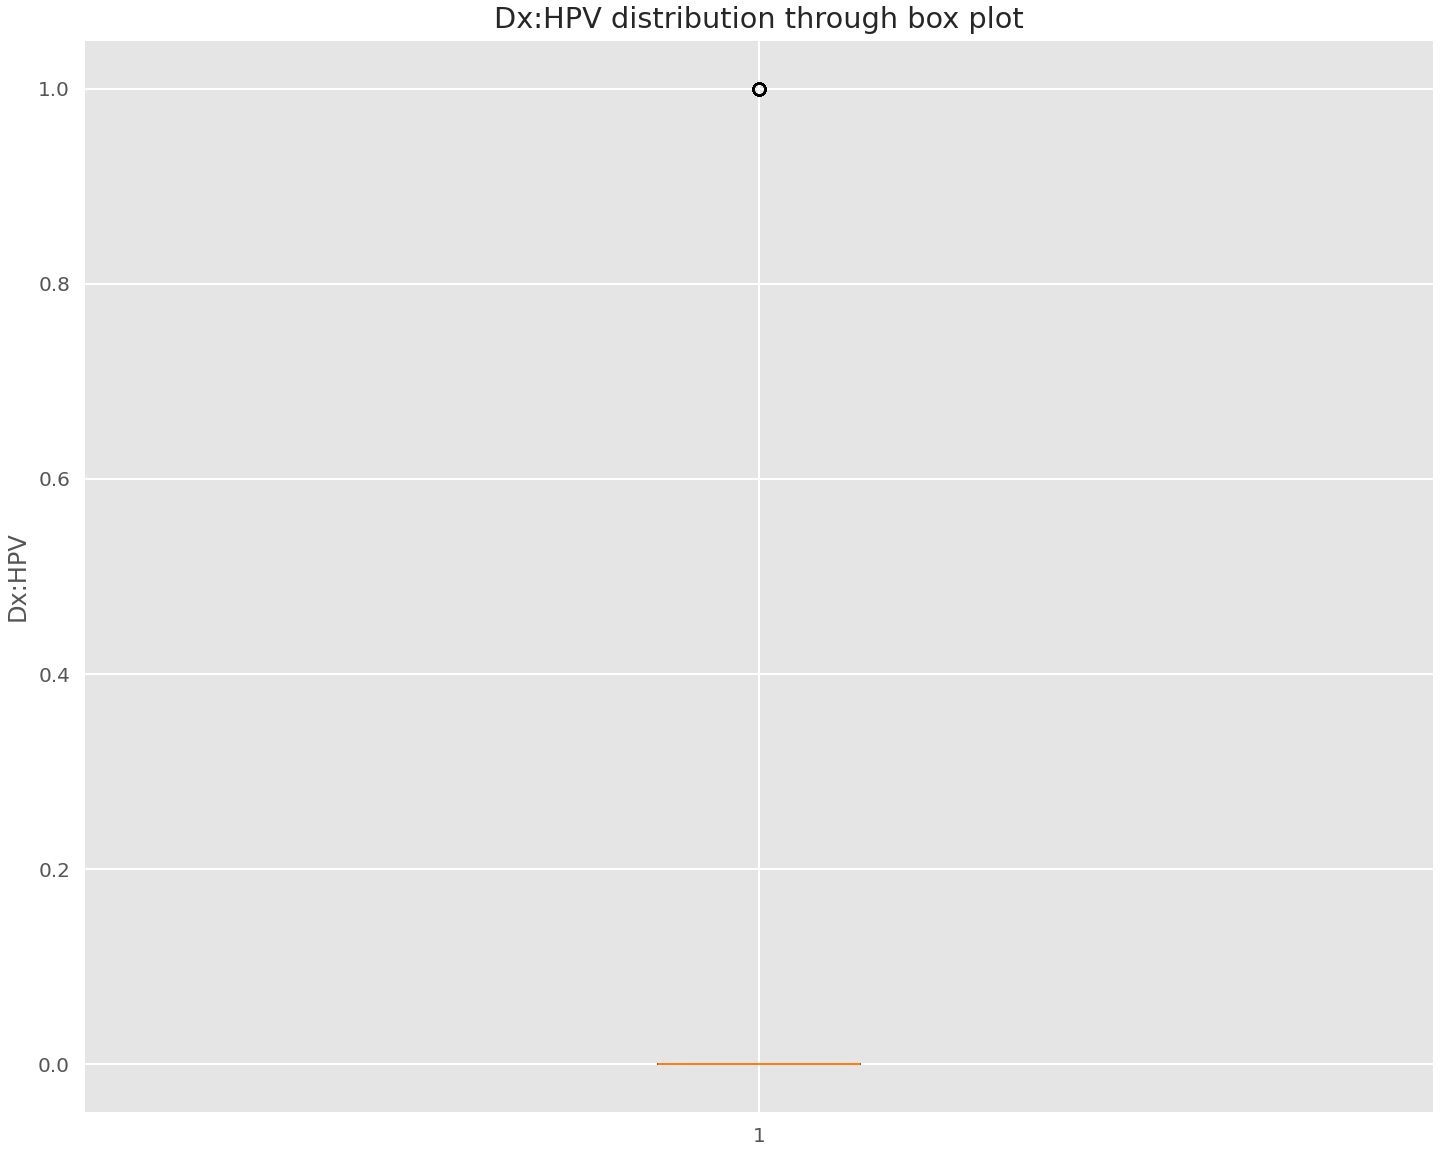

In [ ]:
pn.extension()
heading = "<h3>Dashboard : Outlier detection through box plot</h3>\nPlease feel free to try various combinations of parameters to analyze results from different angles"
text = pnw.StaticText(value=heading, align="center")

dash1 = pn.Column(
                    text,
                    pn.Row(f1, align="center"),
                    pn.Row(create_dash)
                )
dash1

Some features have outliers. These outliers can be handled by scaling features using Robust scaler.

**Data Scaling**

We use [Robust Scaler]('https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html') to Scale features using statistics that are robust to outliers.

This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [ ]:
# Scale our continuous data in the range of 0 & 1
from sklearn.preprocessing import RobustScaler
# define min max scaler
robust_scaler = RobustScaler().fit(X_train)
# transform data
X_train_scaled = robust_scaler.transform(X_train)

In [ ]:
# Create a dataframe for scaled data
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_train_scaled.head()

Dx:HPV   Dx  ...  STDs (number)  First sexual intercourse
0     0.0  0.0  ...            0.0                  3.000000
1     0.0  0.0  ...            0.0                  0.000000
2     0.0  0.0  ...            0.0                 -0.333333
3     0.0  0.0  ...            0.0                  0.666667
4     0.0  0.0  ...            1.0                 -0.333333

[5 rows x 18 columns]

In [ ]:
# Perform scaling for validation & test data
X_val_scaled = robust_scaler.transform(X_val)
X_test_scaled = robust_scaler.transform(X_test)

In [ ]:
# Create a dataframe for scaled text & val data
X_val_scaled = pd.DataFrame(X_val_scaled,columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_test.columns)

### **Data Visualization**

In [ ]:
# Merge X_train_scaled & y_train for Data Visualization
df_train = pd.merge(X_train,y_train, left_index=True, right_index=True)
df_train.head()

Dx:HPV   Dx  ...  First sexual intercourse  Dx:Cancer
7       0.0  0.0  ...                      26.0        0.0
192     0.0  0.0  ...                      17.0        0.0
155     0.0  0.0  ...                      16.0        0.0
319     0.0  0.0  ...                      19.0        0.0
101     0.0  0.0  ...                      16.0        0.0

[5 rows x 19 columns]

In [ ]:
df_train['Dx:Cancer'].value_counts()

0.0    673
1.0     13
Name: Dx:Cancer, dtype: int64

In [ ]:
# Change label 0 & 1 to Positive & Negative
df_train['Dx:Cancer'] = df_train['Dx:Cancer'].apply(lambda x : 'Cancer positive' if x == 1 else 'Cancer negative')
df_train['Dx:Cancer'].head()

7      Cancer negative
192    Cancer negative
155    Cancer negative
319    Cancer negative
101    Cancer negative
Name: Dx:Cancer, dtype: object

Let's see what is in the data through visualization.

In [ ]:
# Define create_figure function for creating a Dashboard
import matplotlib.gridspec as gridspec

def create_figure(plot1_f1,plot1_f2, plot2_f,plot3_f):
    with plt.style.context(("seaborn","ggplot")):
        fig = plt.figure(constrained_layout=True, figsize=(10,8))
        specs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig) ## Declaring 2x2 figure.

        ax1 = fig.add_subplot(specs[0, :]) ## First Row
        ax2 = fig.add_subplot(specs[1, 0]) ## Second Row First Column
        ax3 = fig.add_subplot(specs[1, 1]) ## Second Row Second Colums

        ## First Graph -  Scatter Plot
        color = {'Cancer positive' : "tab:green", 'Cancer negative':"tab:red"}
        for label in df_train["Dx:Cancer"].unique():
            ax1.scatter(df_train[df_train["Dx:Cancer"]==label][plot1_f1],
                        df_train[df_train["Dx:Cancer"]==label][plot1_f2],
                        c=color[label],
                        s=25,
                        alpha=0.5,
                        label=label)
        ax1.set_xlabel(plot1_f1)
        ax1.set_ylabel(plot1_f2)
        ax1.set_title("%s vs %s Scatter Plot"%(plot1_f1, plot1_f2))
        ax1.legend(title="target",loc="best")

        ## Second Graph - Bar Chart
        avg_feature_per_class = df_train.groupby(by="Dx:Cancer").mean()[[plot2_f]]
        ax2.bar(avg_feature_per_class.index,
                avg_feature_per_class[plot2_f],
                color="tab:blue",
                width=0.6)
        ax2.set_ylabel(plot2_f)
        ax2.set_title("Average %s per class"%(plot2_f))

        ## Third Graph - Histogram
        ax3.hist(df_train[plot3_f], color="tab:orange", )
        ax3.set_ylabel(plot3_f)
        ax3.set_title("%s distribution"%(plot3_f))

        plt.close(fig)
        return fig

### Create a Dashboard

We start by creating 1 dropdown which will have all features as options. We also have given names to each dropdown about which parameter it belongs to.

In [ ]:
f1 = pnw.Select(options=list(df_train.columns.to_list()), name="Scatter Plot Feature 1")
f2 = pnw.Select(options=list(df_train.columns.to_list()), name="Scatter Plot Feature 2")
f3 = pnw.Select(options=list(df_train.columns.to_list()), name="Bar Chart Feature")
f4 = pnw.Select(options=list(df_train.columns.to_list()), name="Histogram Feature")

We can link the above-mentioned widgets to a parameter of our method by creating wrapper function around it and giving it decorator (@pn.depends) as mentioned below. It'll link the value of these widgets with a value of a function.

In [ ]:
@pn.depends(f1.param.value,f2.param.value,f3.param.value,f4.param.value)
def create_dash(f1,f2,f3,f4):
    return create_figure(f1,f2,f3,f4)

Column
    [0] StaticText(align='center', value='<h3>Dashboard :...)
    [1] Row(align='center')
        [0] Select(name='Scatter Plot Feature 1', options=['Dx:HPV', 'Dx', ...], value='Dx:HPV')
        [1] Select(name='Scatter Plot Feature 2', options=['Dx:HPV', 'Dx', ...], value='Dx:HPV')
    [2] Row(align='center')
        [0] Select(name='Bar Chart Feature', options=['Dx:HPV', 'Dx', ...], value='Dx:HPV')
        [1] Select(name='Histogram Feature', options=['Dx:HPV', 'Dx', ...], value='Dx:HPV')
    [3] Row
        [0] ParamFunction(function)
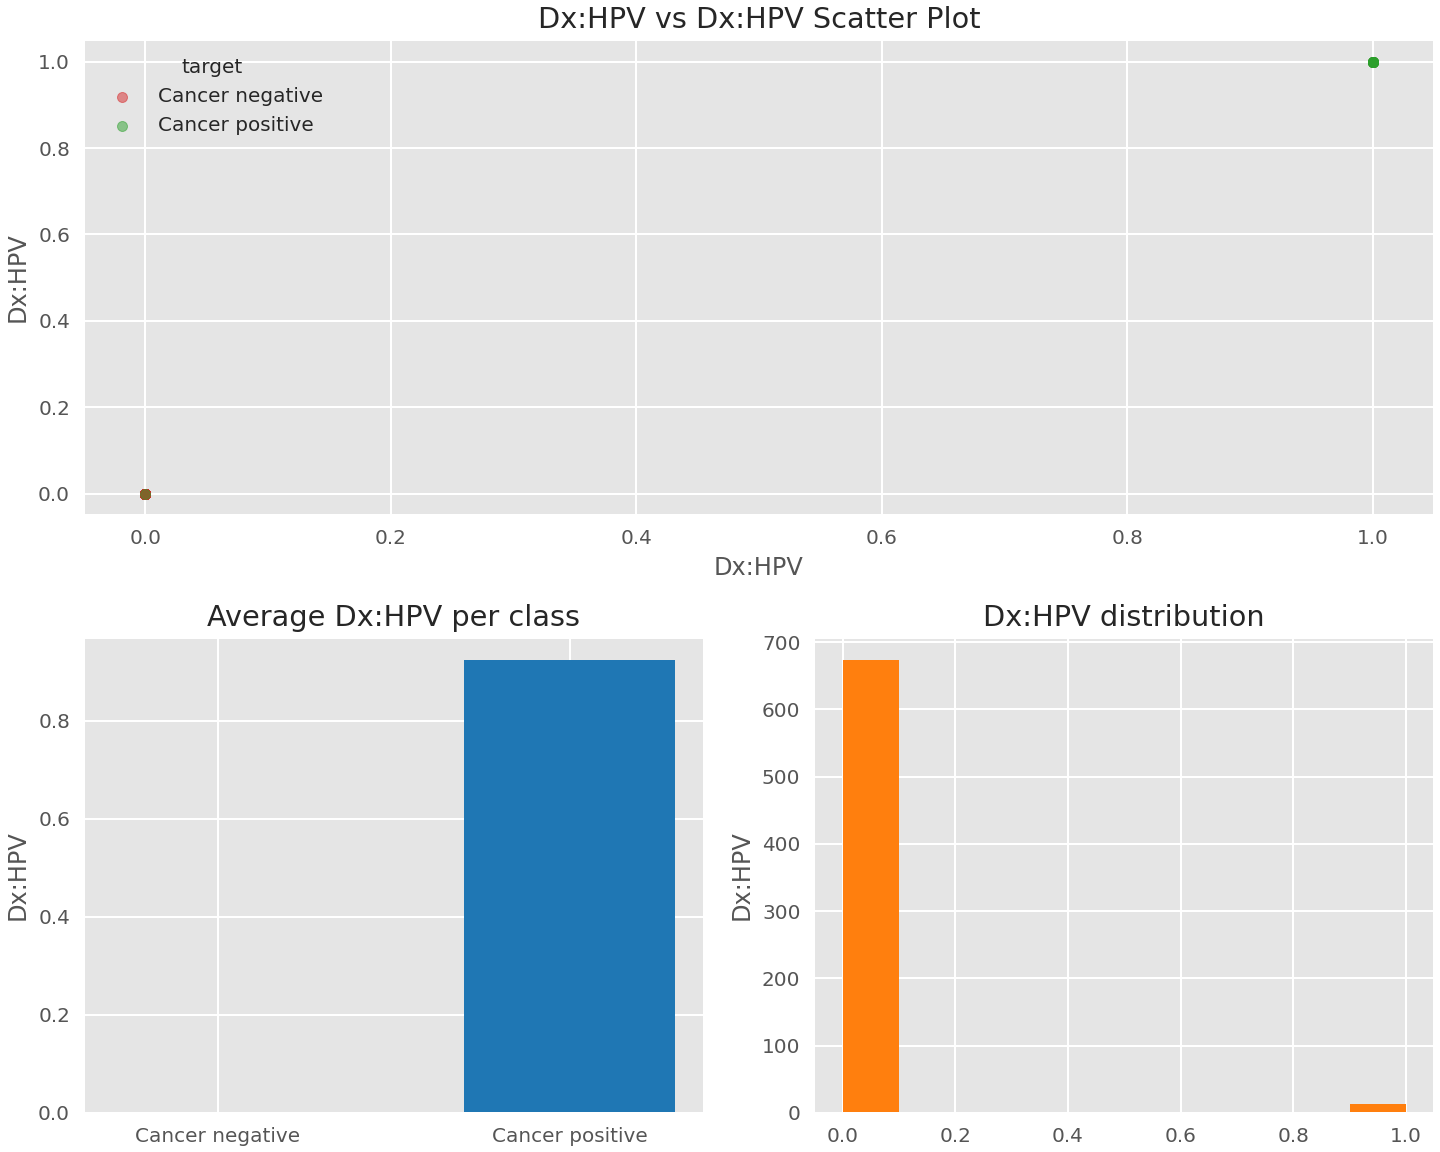

In [ ]:
pn.extension()
heading = "<h3>Dashboard : Cervical cancer data analysis </h3>\nPlease feel free to try various combinations of parameters to analyze results from different angles"
text = pnw.StaticText(value=heading, align="center")

dash = pn.Column(
                    text,
                    pn.Row(f1,f2, align="center"),
                    pn.Row(f3,f4, align="center"),
                    pn.Row(create_dash)
                )
dash

Building ML models for Cervicular cancer classification.

We are building 3 ML models for this project:

* Logistic Regression as a Base Classifier
* LGBM (Light Gradient Boosting Machine)
* XGBM (eXtream Gradient Boosting Machine)

**Handling imbalanced data**

Since our data is imbalanced one, we need to balance the data in order to get better accurate results from our ML models. To balance the data, we are using SMOTE (Synthetic Minority OverSampling Technique). SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

For more details SMOTE, check [here](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
counter= Counter(y_train)
print(f'Before Sampling', counter)
# Oversampling the train data using SMOTE
smt=SMOTE()
X_train_sm,y_train_sm = smt.fit_resample(X_train_scaled,y_train)
counter= Counter(y_train_sm)
print('After Sampling', counter)

Before Sampling Counter({0.0: 673, 1.0: 13})
After Sampling Counter({0.0: 673, 1.0: 673})


### Logistic regression (Base classifier)

In [ ]:
from sklearn.linear_model import LogisticRegression
#Logistic regression model
lr_model_sm=LogisticRegression(random_state=42)
#fitting the lr model
lr_model_sm.fit(X_train_sm,y_train_sm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#Accuracy of the model
lr_score=lr_model_sm.score(X_train_sm,y_train_sm)
print('Accuracy of the trained lr_model :',lr_score)

Accuracy of the trained lr_model : 0.9992570579494799


In [ ]:
%%time
#Cross validation prediction for Logistic prediction
cv_predict=cross_val_predict(lr_model_sm,X_test_scaled,y_test,cv=5)
#Cross validation score
cv_score=cross_val_score(lr_model_sm,X_test_scaled,y_test,cv=5)
print('cross_val_score :',np.average(cv_score))

cross_val_score : 0.9653594771241829
CPU times: user 126 ms, sys: 94.1 ms, total: 220 ms
Wall time: 112 ms


Accuracy of the model is not the best metric to use when evaluating the model on imbalanced datasets as it may be misleading. So, we are going to use Confusion matrix, & AUC score from ROC for checking model performance

**Confusion matrix**

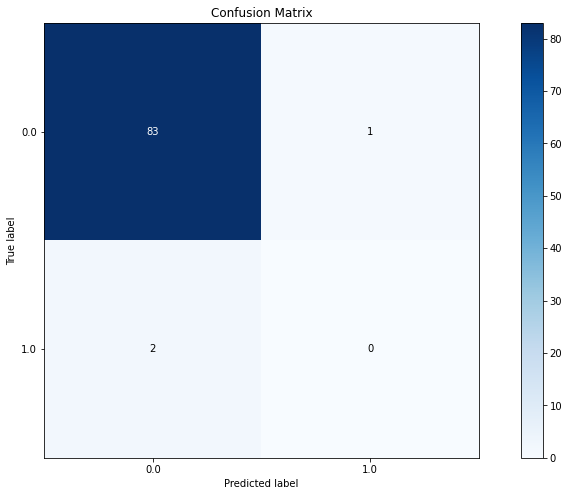

In [ ]:
#Confusion matrix
cm=confusion_matrix(y_test, cv_predict)
#Plot the confusion matrix
plot_confusion_matrix(y_test, cv_predict, normalize=False,figsize=(15,8))

**Classification Report**

In [ ]:
class_report= classification_report(y_test, cv_predict)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98        84
         1.0       0.00      0.00      0.00         2

    accuracy                           0.97        86
   macro avg       0.49      0.49      0.49        86
weighted avg       0.95      0.97      0.96        86



**Reciever operating characteristics (ROC)- Area under curve(AUC) score**

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.

The ROC curve is plotted with TPR (True Positive Rate) against the FPR(False Positive Rate) where TPR is on the y-axis and FPR is on the x-axis.

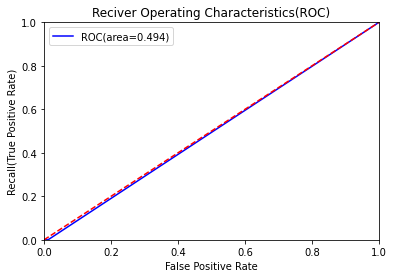

AUC: 0.49404761904761907


In [ ]:
#ROC_AUC curve
plt.figure()
false_positive_rate, recall, thresholds=roc_curve(y_test,cv_predict)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate, recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

Insights:
* Logistic model not at all learnng clas 1 during training. Hence it is not able to predict class correctly (recall = 0).This may due to the non-linear behaviour of the data.

**LightGBM model**

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

Faster training speed and higher efficiency.
Lower memory usage.
Better accuracy.
Support of parallel and GPU learning.
Capable of handling large-scale data.
The trees in LightGBM have a leaf-wise growth, rather than a level-wise growth. After the first split, the next split is done only on the leaf node that has a higher delta loss.

choosing hyperparameters

In [ ]:
#Selecting best hyperparameters by tuning of different parameters
params={'boosting_type': 'gbdt', 
          'max_depth' : -1, #no limit for max_depth if <0
          'objective': 'binary',
          'metric':'auc',
          'num_leaves': 100,
          'learning_rate': 0.001,
          'subsample': 1,
          'lambda_l2':0.05,
          'min_split_gain': 0.45, 
          'min_child_samples': 5,
          }

In [ ]:
#Creating datasets for LGBM
#training data
lgb_train=lgb.Dataset(X_train_sm,label=y_train_sm)
#validation data
lgb_val=lgb.Dataset(X_val_scaled,label=y_val)
#test data
lgb_test=lgb.Dataset(X_test_scaled,label=y_test)

Training LGBM model

In [ ]:
num_rounds=10000
lgbm= lgb.train(params,lgb_train,num_rounds,valid_sets=[lgb_train,lgb_val],verbose_eval=1000,early_stopping_rounds = 5000)
lgbm

Training until validation scores don't improve for 5000 rounds.
[1000]	training's auc: 0.999992	valid_1's auc: 1
[2000]	training's auc: 0.999998	valid_1's auc: 1
[3000]	training's auc: 0.999998	valid_1's auc: 1
[4000]	training's auc: 0.999998	valid_1's auc: 1
[5000]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 0.99925	valid_1's auc: 1


LGBM model performance on test data

In [ ]:
# model prediction
#probability predictions
lgbm_predict_prob=lgbm.predict(X_test_scaled,random_state=42,num_iteration=lgbm.best_iteration)
#Convert to binary output 1 or 0
lgbm_predict=np.where(lgbm_predict_prob>=0.5, 1, 0)
lgbm_test_scores = X_test.reset_index(drop=True)
lgbm_test_scores['Prediction scores'] = lgbm_predict_prob
lgbm_test_scores['Predictions'] = lgbm_predict
lgbm_test_scores

Dx:HPV   Dx  ...  Prediction scores  Predictions
0      0.0  0.0  ...           0.499502            0
1      0.0  0.0  ...           0.499502            0
2      0.0  0.0  ...           0.499502            0
3      0.0  0.0  ...           0.499502            0
4      0.0  0.0  ...           0.499502            0
..     ...  ...  ...                ...          ...
81     0.0  0.0  ...           0.499502            0
82     0.0  0.0  ...           0.499502            0
83     0.0  0.0  ...           0.499502            0
84     0.0  0.0  ...           0.499502            0
85     0.0  0.0  ...           0.499502            0

[86 rows x 20 columns]

**Confusion matrix**

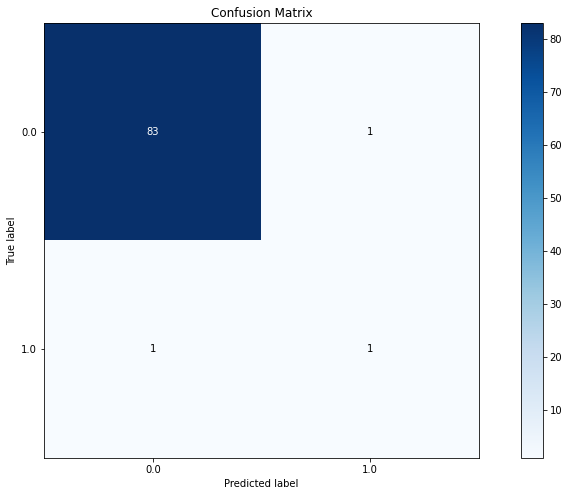

In [ ]:
#Confusion matrix
cm=confusion_matrix(y_test, lgbm_predict )
#Plot the confusion matrix
plot_confusion_matrix(y_test, lgbm_predict, normalize=False,figsize=(15,8))

**Classification Report**

In [ ]:
class_report= classification_report(y_test, lgbm_predict)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99        84
         1.0       0.50      0.50      0.50         2

    accuracy                           0.98        86
   macro avg       0.74      0.74      0.74        86
weighted avg       0.98      0.98      0.98        86



**Reciever operating characteristics (ROC)- Area under curve(AUC) score**

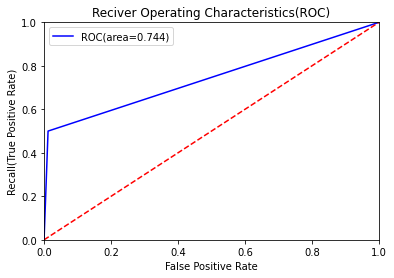

AUC: 0.7440476190476191


In [ ]:
#ROC_AUC curve
plt.figure()
false_positive_rate, recall, thresholds=roc_curve(y_test,lgbm_predict)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate, recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

Insights:

* LGBM performance on test data  is good with AUC of 0.74.

**XGBOOST model**

In [ ]:
import xgboost as xgb

#Creating datasets for XGboost
#training data
xgb_train=xgb.DMatrix(X_train_sm,label=y_train_sm, feature_names=X_train_scaled.columns.tolist())
#validation data
xgb_val=xgb.DMatrix(X_val_scaled,label=y_val,feature_names=X_val_scaled.columns.tolist())
#validation data
xgb_test=xgb.DMatrix(X_test_scaled,label=y_test, feature_names=X_test_scaled.columns.tolist())

Choosing Hyerparameters

In [ ]:
#Selecting best hyperparameters by tuning of different parameters
param={'boosting_type': 'gbtree', 
          'max_depth' : 6,
          'objective': 'binary:logistic',
          'metric':'auc',
          'num_leaves': 30,
          'learning_rate': 0.001,
          'subsample': 0.8,
          'lambda_l2':0.4,
          'min_child_samples': 15,
          'random_state':42
          }

Training the XGBoost model

In [ ]:
num_round = 1000
evallist = ([(xgb_val, 'eval'),(xgb_train, 'train')])
bst = xgb.train(param, xgb_train, num_round, evallist,early_stopping_rounds=100)
bst

[0]	eval-error:0	train-error:0.001486
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 100 rounds.
[1]	eval-error:0	train-error:0.001486
[2]	eval-error:0	train-error:0.001486
[3]	eval-error:0	train-error:0.001486
[4]	eval-error:0	train-error:0.001486
[5]	eval-error:0	train-error:0.001486
[6]	eval-error:0	train-error:0.001486
[7]	eval-error:0	train-error:0.001486
[8]	eval-error:0	train-error:0.001486
[9]	eval-error:0	train-error:0.001486
[10]	eval-error:0	train-error:0.001486
[11]	eval-error:0	train-error:0.001486
[12]	eval-error:0	train-error:0.001486
[13]	eval-error:0	train-error:0.001486
[14]	eval-error:0	train-error:0.001486
[15]	eval-error:0	train-error:0.001486
[16]	eval-error:0	train-error:0.001486
[17]	eval-error:0	train-error:0.001486
[18]	eval-error:0	train-error:0.001486
[19]	eval-error:0	train-error:0.001486
[20]	eval-error:0	train-error:0.001486
[21]	eval-error:0	train-error:0.001486
[22]

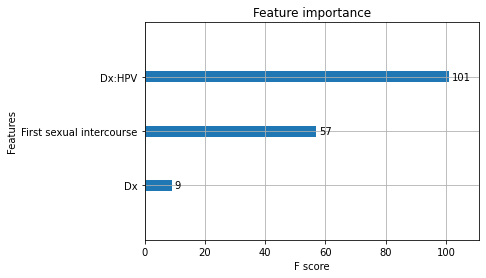

In [ ]:
# Plot feature importance for top 10 features
xgb.plot_importance(bst,max_num_features=10)

**XGBM model performance on test data**

In [ ]:
# model prediction
#probability predictions
xgbm_pred_prob = bst.predict(xgb_test, ntree_limit=bst.best_ntree_limit)
#Convert to binary output 1 or 0
xgbm_predict=np.where(xgbm_pred_prob>=0.5, 1, 0)
xgbm_test_scores = X_test.reset_index(drop=True)
xgbm_test_scores['Prediction scores'] = xgbm_pred_prob
xgbm_test_scores['Predictions'] = xgbm_predict
xgbm_test_scores

Dx:HPV   Dx  ...  Prediction scores  Predictions
0      0.0  0.0  ...           0.499506            0
1      0.0  0.0  ...           0.499506            0
2      0.0  0.0  ...           0.499506            0
3      0.0  0.0  ...           0.499506            0
4      0.0  0.0  ...           0.499506            0
..     ...  ...  ...                ...          ...
81     0.0  0.0  ...           0.499506            0
82     0.0  0.0  ...           0.499506            0
83     0.0  0.0  ...           0.499506            0
84     0.0  0.0  ...           0.499506            0
85     0.0  0.0  ...           0.499506            0

[86 rows x 20 columns]

**Confusion matrix**

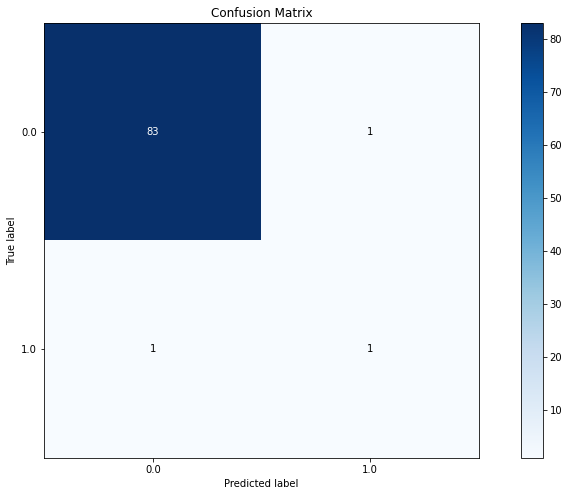

In [ ]:
#Confusion matrix
cm=confusion_matrix(y_test, xgbm_predict )
#Plot the confusion matrix
plot_confusion_matrix(y_test, xgbm_predict, normalize=False,figsize=(15,8))

**Classification Report**

In [ ]:
class_report= classification_report(y_test, xgbm_predict)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99        84
         1.0       0.50      0.50      0.50         2

    accuracy                           0.98        86
   macro avg       0.74      0.74      0.74        86
weighted avg       0.98      0.98      0.98        86



**Reciever operating characteristics (ROC)- Area under curve(AUC) score**

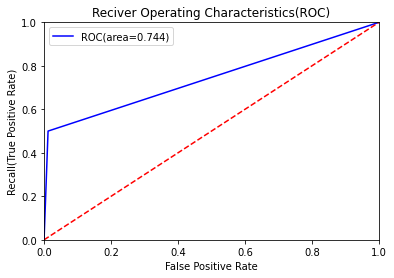

AUC: 0.7440476190476191


In [ ]:
#ROC_AUC curve
plt.figure()
false_positive_rate, recall, thresholds=roc_curve(y_test,xgbm_predict)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate, recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

Insights:

* Surprisingly, XGBM performance is similar to LGBM. We got AUC of 0.744.

#### Final results

In [ ]:
Results={
    'Model':['Base (Logistic Regression)','LGBM','XGBM'],
    'f1-score (Weighted average)':[0.96, 0.98, 0.98],
    'AUC':[0.494, 0.744, 0.744]
}

results_df=pd.DataFrame(Results)
results_df

Model  f1-score (Weighted average)    AUC
0  Base (Logistic Regression)                         0.96  0.494
1                        LGBM                         0.98  0.744
2                        XGBM                         0.98  0.744

**Conclusions**:

* Among all models, LGBM & XGBM models are best with AUC score of 0.744 & f1-score of 0.98.
* Surprisingly, performance of LGBM & XGBM models are similar for our dataset
* Logistic model is a poor classifier for our data with AUC of 0.494 & f1-score of 0.96.
* Model performance can be improved by adding more data with high positive samples.

**References:**        
Dataset: https://www.kaggle.com/loveall/cervical-cancer-risk-classification